
# Linear Equations



## Outline 

1. Setup
2. Special cases
3. L-U Factorization
4. Pivoting
5. Benchmarking
6. Ill conditioning
7. Iterative methods
8. Resources


## Setup

The linear equation is the most elementary problem that arises in computational economic analysis. In a linear equation, an $n \times n$ matrix $A$ and an n-vector $b$ are given, and one must compute the $n$-vector $x$ that satisfies
$Ax = b$.

Linear equations arise naturally in many  economic applications such as

- Linear multicommodity market equilibrium models
- Finite-state financial market models 
- Markov chain models 
- Ordinary least squares

They more commonly arise indirectly from numerical solution sto nonlinear and functional equations:

- Nonlinear multicommodity market models
- Multiperson static game models
- Dynamic optimization models
- Rational expectations models 

Applications often require the repeated solution of very large linear equation systems. In these situations, issues regarding speed, storage requirements, and preciseness of the solution of such equations can arise.

In [1]:
import pandas as pd
import numpy as np

from linear_algorithms import forward_substitution
from linear_algorithms import gauss_seidel
from linear_algorithms import solve

from linear_plots import plot_operation_count

from linear_problems import get_ill_problem_1
from linear_problems import get_inverse_demand_problem


## Special cases



We can start with some special cases to develop a basic understanding for the core building blocks for more complicated settings. Let's start with the case of a lower triangular matrix $A$, where we can solve the linear equation by a simple backward or forward substitution. Let's consider the following setup.

$$
A  =  \begin{bmatrix}
   a_{11} & 0      & 0 \\
   a_{21} & a_{22} & 0 \\
   a_{31}   & a_{32} & a_{33} \\
\end{bmatrix}
$$

Consider an algorithmic implementation of forward-substitution as an example.

$$
x_i = \left ( b_i - \sum_{j=1}^{i-1} a_{ij}x_j \right )/a_{ii}
$$

In [2]:
??forward_substitution

Signature: forward_substitution(a, b)
Source:   
def forward_substitution(a, b):
    """Perform forward substitution to solve a system of linear equations.

    Solves a linear equation of type :math:`Ax = b` when for a *lower triangular* matrix
    :math:`A` of dimension :math:`n \\times n` and vector :math:`b` of length :math:`n`.
    The forward subsititution algorithm can be represented as:

    .. math::

       x_i = \\left ( b_i - \\sum_{j=1}^{i-1} a_{ij}x_j \\right )/a_{ii}


    Parameters
    ----------
    a : numpy.ndarray
        Lower triangular matrix of dimension :math:`n \\times n`.
    b : numpy.ndarray
        Vector of length :math:`n`.

    Returns
    -------
    x : numpy.ndarray
        Solution of the linear equations. Vector of length :math:`n`.

    """
    # Get number of rows
    n = a.shape[0]

    # Allocating space for the solution vector
    x = np.zeros_like(b, dtype=np.double)

    # Here we perform the forward-substitution.
    # Initializing  with t

In [3]:
def test_problem():
    A = np.tril(np.random.normal(size=(3, 3)))
    x = np.random.normal(size=3)
    b = np.matmul(A, x)
    return A, b, x


for _ in range(10):
    A, b, x_true = test_problem()
    x_solve = forward_substitution(A, b)
    np.testing.assert_almost_equal(x_solve, x_true)

 <div class="alert alert-success">
    <h3>Questions</h3>  
     <ul>
  <li>How can we make the test code more generic and sample test problems of different dimensions?</li>
  <li>Is there a way to control the randomness in the test function?</li>
  <li>Is there software out there that allows to automate parts of the testing?</li>
    </ul> 
</div>

If we have an upper triangular matrix, we can use backward substitution to solve the linear system

In [4]:
??backward_substitution

Signature: backward_substitution(a, b)
Source:   
def backward_substitution(a, b):
    """Perform backward substitution to solve a system of linear equations.

    Solves a linear equation of type :math:`Ax = b` when for an *upper triangular* matrix
    :math:`A` of dimension :math:`n \\times n` and vector :math:`b` of length :math:`n`.

    Parameters
    ----------
    a : numpy.ndarray
        Lower triangular matrix of dimension :math:`n \\times n`.
    b : numpy.ndarray
        Vector of length :math:`n`.

    Returns
    -------
    x : numpy.ndarray
        Solution of the linear equations. Vector of length :math:`n`.

    """
    # Get number of rows.
    n = a.shape[0]

    x = np.zeros(n)

    for i in range(n - 1, -1, -1):
        tmp = b[i]
        for j in range(n - 1, i, -1):
            tmp -= x[j] * a[i, j]

        x[i] = tmp / a[i, i]

    return x
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/linear_eq

 <div class="alert alert-warning">
    <h3>Exercises</h3>  
     <ul>
  <li>Implement the same testing setup as above the backward-substitution function.</li>
    </ul> 
</div>

We can now build on these two functions to tackle more complex tasks. This is a good example on how to develop scientific software step-by-step ensuring that each component is well tested before integrating into more involved settings.


## L-U Factorization
        


Most linear equations encountered in practice, however, do not have a triangular $A$ matrix. Doolittle and Crout have shown that any matrix $A$ can be decomposed into the product of a (row-permuted) lower and upper triangular matrix $L$ and $U$, respectively $A=L \times U$ using **Gaussian elimination**. We will not look into the Gaussian elimination algorithm, but there is an example application in our textbook where you can follow along step by step. The L-U algorithm is designed to decompose the $A$ matrix into the product of lower and upper triangular matrices, allowing the linear equation to be solved using a combination of backward and forward substitution. Adding to this the two building blocks we developed earlier `forward_substitution` and `backward_substitution`, we can now write a quite generic function to solve systems of linear equations. 

In [5]:
??solve

Signature: solve(a, b)
Source:   
def solve(a, b):
    """Solve linear equations using L-U factorization.

    Solves a linear equation of type :math:`Ax = b` when for a nonsingular square matrix
    :math:`A` of dimension :math:`n \\times n` and vector :math:`b` of length :math:`n`. Decomposes
    Algorithm decomposes matrix :math:`A` into the product of lower and upper triangular matrices.
    The linear equations can then be solved using a combination of forward and backward
    substitution.

    Two stages of the L-U algorithm:

    1. Factorization using Gaussian elimination: :math:`A=LU` where :math:`L` denotes
    a row-permuted lower triangular matrix. :math:`U` denotes a row-permuted upper
    triangular matrix.

    2. Solution using forward and backward substitution. The factored linear equation of step 1 can
    be expressed as

    .. math::

       Ax = (LU)x = L(Ux) = b

    The forward substitution algorithm solves :math:`Ly = b` for y. The backward substitution
    al

Let's see if this is actually working.

In [6]:
A = np.array([[3, 1], [1, 2]])
x_true = np.array([9, 8])
b = A @ x_true
x_solve = solve(A, b)
np.testing.assert_almost_equal(x_true, x_solve)

## Pivoting


Rounding error can cause serious error when solving linear equations. Let's consider the following linear equations. Let's consider the following example, where $\epsilon$ is a tiny number.

\begin{aligned}
\begin{bmatrix}
   \epsilon & 1 \\
   1 & 1 \\
\end{bmatrix} 
\begin{bmatrix}
   x_1 \\
   x_2 \\
\end{bmatrix} 
= 
\begin{bmatrix}
1 \\
2\\
\end{bmatrix} 
\end{aligned}

It is easy to verify that the right solution is

\begin{aligned}
x_1 & = \frac{1}{1 - \epsilon} \\
x_2 & = \frac{1 - 2 \epsilon}{1 - \epsilon} \\
\end{aligned}

and thus $x_1$ is slightly more than one and $x_2$ is slightly less than one. To solve the system using Gaussian elimination we need to add $-1/\epsilon$ times the first row to the second row. We end up with


\begin{aligned}
\begin{bmatrix}
   \epsilon & 1 \\
   0 & 1 - \frac{1}{\epsilon} \\
\end{bmatrix} 
\begin{bmatrix}
   x_1 \\
   x_2 \\
\end{bmatrix} 
= 
\begin{bmatrix}
1 \\
2 - \frac{1}{\epsilon}\\
\end{bmatrix} 
\end{aligned}

which we can then solve recursively.

\begin{aligned}
x_2 & = \frac{2 - 1/\epsilon}{1 - 1/\epsilon} \\
x_1 & = \frac{1 - x_2}{\epsilon}
\end{aligned}


Let's translate this into code.

In [7]:
eps = 1e-17
A = np.array([[eps, 1], [1, 1]])
b = np.array([1, 2])
solve(A, b)

array([0., 1.])

We can now use our solution algorithm, but have to realize that the results are grossly inaccurate. What happened? Is there any hope to apply `numpy`'s routine?

In [8]:
np.linalg.solve(A, b)

array([1., 1.])

This algorithm  does automatically check whether such rounding errors can be avoided by simply changing the order of rows. This is called **pivoting** and changes the recursive solution to

\begin{aligned}
x_2 & = \frac{1 - 2\epsilon}{1 - \epsilon} \\
x_1 & = 2 - x_2
\end{aligned}

which can be solved more accurately. Our implementation also solves the modified problem well. 

In [9]:
A = np.array([[1, 1], [eps, 1]])
b = np.array([2, 1])
solve(A, b)

array([1., 1.])

Building your own numerical routines is usually the only way to really understand the algorithms and learn about all the potential pitfalls. However, the default should be to rely on battle-tested production code. For linear algebra there are numerous well established libraries available. Building your own numerical routines is usually the only way to really understand the algorithms and learn about all the potential pitfalls. However, the default should be to rely on battle-tested production code. For linear algebra there are numerous well established libraries available.


## Benchmarking



How does solving a system of linear equations by an $L-U$ decomposition compare to other alternatives of solving the system of linear equations.

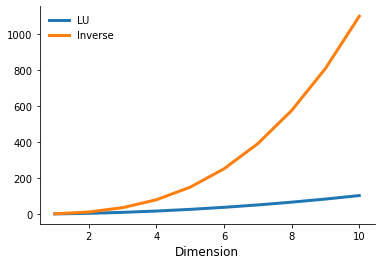

In [10]:
plot_operation_count()

The right setup for your numerical needs depends on your particular problem. For example, this trade-off looks very different if you have to solve numerous linear equations that only differ in $b$ but not $A$. In this case you only need to compute the inverse once.

 <div class="alert alert-warning">
    <h3>Exercises</h3>  
     <ul>
  <li>Set up a benchmarking exercise that compares the time to solution for the two approaches for $m=\{1, 100\}$ and $n = \{50, 100\}$.</li> where $n$ denotes the number of linear equations and $m$ the number of repeated solutions.
    </ul> 
</div>


## Ill conditioning


Some linear equations are inherently difficult to solve accurately on a computer. This difficulty occurs when the A matrix is structured in such a way that a small perturbation $\delta b$ in the data vector $b$ induces a large change $\delta x$ in the solution vector $x$. In such cases the linear equation or, more generally, the $A$ matrix is said to be **ill conditioned**.

One measure of ill conditioning in a linear equation Ax = b is the “elasticity” of the solution vector $x$ with respect to the data vector $b$ 

$$
\epsilon = \sup_{||\delta  b|| > 0} \frac{||\delta x|| / ||x||}{||\delta b|| / ||b||}
$$

The elasticity gives the maximum percentage change in the size of the solution vector $x$ induced by a $1$ percent change in the size of the data vector $b$. If the elasticity is large, then small errors in the computer representation of the data vector $b$ can produce large errors in the computed solution vector x. Equivalently, the computed solution $x$ will have far fewer significant digits than the data vector $b$.

In practice, the elasticity is estimated using the condition number of the matrix $A$, which for invertible $A$ is defined by $\kappa \equiv ||A|| \cdot ||A^{-1} ||$. The condition number is always greater than or equal to one. Numerical analysts often use the rough rule of thumb that for each power of $10$ in the condition number, one significant digit is lost in the computed solution vector $x$. Thus, if $A$ has a condition number of $1,000$, the computed solution vector $x$ will have about three fewer significant digits than the data vector $b$.

Let's look at an example, where the solution vector is all ones but but the linear equation is notoriously ill-conditioned.

In [11]:
??get_ill_problem_1

Signature: get_ill_problem_1(n)
Source:   
def get_ill_problem_1(n):
    """Create ill problem (1)."""
    a = np.vander(1 + np.arange(n))
    x = np.ones(n)
    b = a @ x

    return a, b, x
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/linear_equations/linear_problems.py
Type:      function


How does the solution error depend on the condition number in this setting.

In [12]:
rslt = dict((("Condition", []), ("Error", []), ("Dimension", [])))
grid = [5, 10, 15, 25]

for n in grid:
    A, b, x_true = get_ill_problem_1(n)
    x_solve = np.linalg.solve(A, b)
    rslt["Condition"].append(np.linalg.cond(A))
    rslt["Error"].append(np.linalg.norm(x_solve - x_true, 1))
    rslt["Dimension"].append(n)

In [13]:
pd.DataFrame.from_dict(rslt)

,Condition,Error,Dimension
0,2.616969e+04,5.759837e-13,5
1,2.106258e+12,1.611891e-06,10
2,2.582411e+21,3.938990e+02,15
3,2.035778e+22,5.435456e+05,25


Let's consider the following example as well, which is taken from Johansson (2015).

$$
\left[\begin{array}{c} 1 \\ 2 \end{array}\right] = \begin{bmatrix} 1 & \sqrt{p}\\ 1 & \frac{1}{\sqrt{p}} \end{bmatrix} \times \left[ \begin{array}{c} x_1 \\ x_2 \end{array} \right]
$$

This system is singular for $p=1$ and for $p$ in the vicinity of one is ill conditioned.

 <div class="alert alert-warning">
    <h3>Exercises</h3>  
     <ul>
  <li>Create two plots that show the condition number and the error between the analytic and numerical solution.</li>
    </ul> 
</div>


## Iterative methods


Algorithms based on Gaussian elimination are called exact or, more properly, direct methods because they would generate exact solutions for the linear equation $Ax = b$ after a finite number of operations, if not for rounding error. Such methods are ideal for moderately sized linear equations but may be impractical for large ones. Other methods, called iterative methods, can often be used to solve large linear equations more efficiently if the $A$ matrix is sparse, that is, if $A$ is composed mostly of zero entries. Iterative methods are designed to generate a sequence of increasingly accurate approximations to the solution of a linear equation, but they generally do not yield an exact solution after a prescribed number of steps, even in theory.


The most widely used iterative methods for solving a linear equation $Ax = b$ are developed by choosing an easily invertible matrix $Q$ and writing the linear equation in the equivalent form

$$
Qx = b + (Q - A)x
$$

or 

$$
x = Q^{-1} b + (I - Q^{-1} A)x
$$

This form of the linear equation suggests the iteration rule 

$$
x^{k+1}\leftarrow Q^{-1} b + (I - Q^{-1} A)x^{k}
$$

which, if convergent, must converge to a solution of the linear equation. Ideally, the so-called splitting matrix $Q$ will satisfy two criteria. First, $Q^{-1}b$ and $Q^{-1} A$ should be relatively easy to compute. This criterion is met if $Q$ is either diagonal or triangular. There are two popular approaches:

* The **Gauss-Seidel** method sets $Q$ equal to the upper triangular matrix formed from the upper triangular elements of $A$.

* The **Gauss-Jacobi** method sets $Q$ equal to the diagonal matrix formed from the diagonal entries of $A$.

In [14]:
??gauss_seidel

Signature:
gauss_seidel(
    a,
    b,
    x0=None,
    lambda_=1.0,
    max_iterations=1000,
    tolerance=1.4901161193847656e-08,
)
Source:   
def gauss_seidel(a, b, x0=None, lambda_=1.0, max_iterations=1000, tolerance=eps):
    """Solves linear equation of type :math:`Ax = b` using Gauss-Seidel iterations.

    In the linear equation, :math:`A` denotes a matrix of dimension
    :math:`n \\times n` and :math:`b` denotes a vector of length :math:`n` The solution
    method performs especially well for larger linear equations if matrix :math`A`is
    sparse. The method achieves fairly precise approximations to the solution but
    generally does not produce *exact* solutions.

    Following the notation in Miranda and Fackler (2004, :cite:`miranda2004applied`),
    the linear equations problem can be written as

    .. math::

       Qx = b + (Q -A)x \\Rightarrow x = Q^{-1}b + (I - Q^{-1}A)x

    which suggest the iteration rule

    .. math::

       x^{(k+1)} \\leftarrow Q^{-1}b + (I

 <div class="alert alert-warning">
    <h3>Exercises</h3>  
     <ul>
  <li>Implement the Gauss-Jacobi method.</li>
    </ul> 
</div>

In [15]:
from linear_solutions_tests import gauss_jacobi  # noqa: E402

Let's conclude with an economic application as outlined in Judd (1998). Suppose we  have the following inverse demand function $p = 10 - q$ and the following supply curve $q = p / 2 +1$. Equilibrium is where supply equals demand and thus we need to solve the following linear system.

$$
\left[\begin{array}{c} 10 \\ -2 \end{array}\right] = \begin{bmatrix} 1 & 1\\ 1 & -2\end{bmatrix} \times \left[ \begin{array}{c} p \\ q \end{array} \right]
$$

In [16]:
A, b, x_true = get_inverse_demand_problem()

Now we can compre the two solution approaches and make sure that they in fact give the same result.

In [17]:
x_seidel = gauss_seidel(A, b)
x_jacobi = gauss_jacobi(A, b)
np.testing.assert_almost_equal(x_seidel, x_jacobi)


## Resources


#### Software

* **The PARDISO Solver Project**: https://www.pardiso-project.org

* **LAPACK — Linear Algebra PACKage**: http://www.netlib.org/lapack


#### References

- Robert Johansson. *Numerical Python: scientific computing and data science applications with NumPy, SciPy and Matplotlib*. Apress, 2018.

- William H Press, Brian P Flannery, Saul A Teukolsky, and William T Vetterling. *Numerical recipes: The art of scientific computing*. Cambridge University Press, 1986.
